# **Many to One**

In [1]:
# LSTM 예시 : Noisy Sine 그래프를 예측해 본다.
# Many-to-one 방식
#
# 2020.03.30, 아마추어퀀트 (조성현)
# -------------------------------------------
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2차원 배열의 feature 데이터로 LSTM 학습 데이터를 만든다.
def build_train_data(data, t_step, n_jump = 1):
    n_data = data.shape[0]   # number of data
    n_feat = data.shape[1]   # number of features

    m = np.arange(0, n_data - t_step, n_jump)   # m =  [0, 1, 2, 3, 4, 5]
    x = [data[i:(i+t_step), :] for i in m]      # feature data
    y = [data[i, :] for i in (m + t_step)]      # target data

    # shape을 조정한다. feature = 3D, target = 2D
    x_data = np.reshape(np.array(x), (len(m), t_step, n_feat))
    y_target = np.reshape(np.array(y), (len(m), n_feat))
    
    return x_data, y_target

# 시계열 데이터 (noisy sin)
#sine = np.sin(2 * np.pi * 0.03 * np.arange(1001))   # sine 곡선
sine = np.sin(2 * np.pi * 0.03 * np.arange(1001)) + np.random.random(1001) # trend & noisy sine

sine

array([0.74403722, 0.39887056, 0.9555891 , ..., 0.36520115, 0.70765759,
       0.31680518])

Model: "model"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
input_1 (InputLayer)                                  [(None, 20, 1)]                                 0                 
________________________________________________________________________________________________________________________
bidirectional (Bidirectional)                         (None, 100)                                     20800             
________________________________________________________________________________________________________________________
dense (Dense)                                         (None, 1)                                       101               
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
____________________________________________________________________

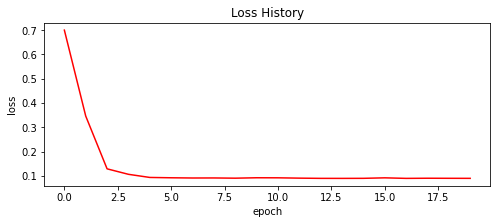

[[0.6922629]]


In [2]:

# 데이터가 데이터프레임 형식으로 되어 있다고 생각하자. feature가 1개이고 target이 없는 데이터임.
# 미래의 sine 값을 target으로 만들어 주고, LSTM을 학습한다.
df = pd.DataFrame({'sine':sine})
df.head()

t_step = 20

# 학습 데이터를 생성한다.
data = np.array(df)
x_train, y_train = build_train_data(data, t_step)
x_train.shape, y_train.shape

n_input = 1
n_output = 1
n_hidden = 50

# LSTM 모델을 생성한다.
x_input = Input(batch_shape=(None, t_step, n_input))
#x_lstm, last_h, last_c = LSTM(n_hidden, return_sequences=True, return_state=True)(x_input) #h=(None,50) >>>many to many
#x_lstm = LSTM(n_hidden,return_sequences=True)(x_input) # 2층구조 ----- 아래에도 ,return_sequences=True 붙여줄것
#x_lstm = LSTM(n_hidden)(x_lstm) # 1층구조 (x_input) >>many to many
x_lstm=Bidirectional(LSTM(n_hidden),merge_mode='concat')(x_input) # 양방향으로 작동 # >>> merge_mode='concat'--- default 값
y_output = Dense(n_output)(x_lstm)
#y_output = TimeDistributed(Dense(n_output))(x_lstm) # >>> many to many h값과 c 값이 둘 다 쓰일 때 (2층구조일때)

model = Model(x_input, y_output)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
model.summary(line_length=120)

#model_1 = Model(x_input,[x_lstm, last_h, last_c])

# 학습한다
h = model.fit(x_train, y_train, epochs=20, batch_size=100, shuffle=True)

# Loss history를 그린다
plt.figure(figsize=(8, 3))
plt.plot(h.history['loss'], color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 최근 t_step 기간의 데이터로 다음 기간의 sine 값을 예측한다.
px = data[-t_step:].reshape(1, t_step, 1)
y_pred = model.predict(px)
print(y_pred)


AttributeError: ignored

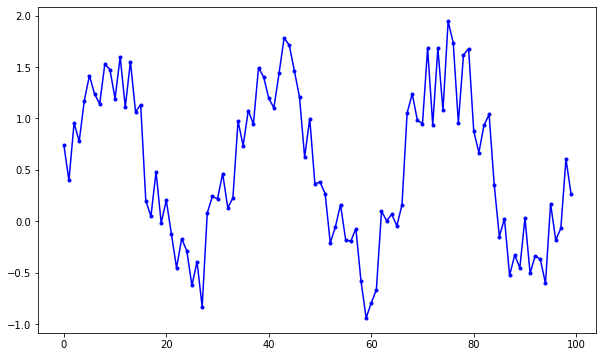

In [3]:
plt.figure(figsize=(10,6))
plt.plot(df[:100],color='blue',marker='o',markersize='3')
plt.plot(df.arange(100,120),color='red',marker='o',markersize='3')
plt.show()

In [ ]:
# 향후 20 기간 데이터를 예측한다. 향후 1 기간을 예측하고, 예측값을 다시 입력하여 2 기간을 예측한다.
# 이런 방식으로 20 기간까지 예측한다.
n_future = 20
n_last = 100
if len(data) > n_last:
    last_data = np.copy(data[-n_last:])  # 원 데이터의 마지막 n_last개만 그려본다
else:
    last_data = np.copy(data)

dx = np.copy(last_data)
estimated = [dx[-1][0]]
for i in range(n_future):
    # 마지막 t_step 만큼 입력데이터로 다음 값을 예측한다
    px = dx[-t_step:].reshape(1, t_step, 1)
    
    # 다음 값을 예측한다.
    y_hat = model.predict(px)[0][0]
        
    # 예측값을 저장해 둔다
    estimated.append(y_hat)
    
    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    dx = np.insert(dx, len(dx), y_hat)

# 원 시계열과 예측된 시계열을 그린다
plt.figure(figsize=(12, 6))
ax1 = np.arange(1, len(last_data) + 1)
ax2 = np.arange(len(last_data), len(last_data) + len(estimated))
plt.plot(ax1, last_data, 'b-o', color='blue', markersize=3, label='Time series', linewidth=1)
plt.plot(ax2, estimated, 'b-o', color='red', markersize=3, label='Estimated')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.legend()
plt.show()







# **Many to Many**






In [ ]:
# LSTM 예시 : Noisy Sine 그래프를 예측해 본다.
# Many-to-one 방식
#
# 2020.03.30, 아마추어퀀트 (조성현)
# -------------------------------------------
from tensorflow.keras.layers import Dense, Input, LSTM, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2차원 배열의 feature 데이터로 LSTM 학습 데이터를 만든다.
def build_train_data(data,t_step,n_jump=1):
  xt=data.shape[0]
  yt=data.shape[1]

  m=np.arange(0,xt-t_step,n_jump)
  x=[data[i:(i+t_step)]for i in m]
  y=[data[(i+1):(i+1+t_step),:]for i in m]

  x_data=np.reshape(np.array(x),(len(m),t_step,yt))
  y_target=np.reshape(np.array(y),(len(m),t_step,yt))

  return x_data,y_target

# 시계열 데이터 (noisy sin)
#sine = np.sin(2 * np.pi * 0.03 * np.arange(1001))   # sine 곡선
sine = np.sin(2 * np.pi * 0.03 * np.arange(1001)) + np.random.random(1001) # trend & noisy sine

sine

array([ 0.46463919,  0.84743353,  0.52405873, ..., -0.20479948,
        0.73909052,  0.17669394])

Model: "model_12"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
input_20 (InputLayer)                                 [(None, 20, 1)]                                 0                 
________________________________________________________________________________________________________________________
bidirectional_3 (Bidirectional)                       (None, 20, 100)                                 20800             
________________________________________________________________________________________________________________________
time_distributed_8 (TimeDistributed)                  (None, 20, 1)                                   101               
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________

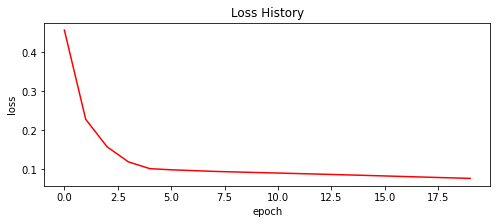

[[[ 0.5103023 ]
  [ 0.38636893]
  [ 0.19958873]
  [-0.00462891]
  [-0.09315841]
  [-0.32837367]
  [-0.40665048]
  [-0.5040585 ]
  [-0.48316237]
  [-0.5193846 ]
  [-0.39969206]
  [-0.35168564]
  [-0.18749082]
  [-0.10312507]
  [ 0.01353481]
  [ 0.11004408]
  [ 0.24915515]
  [ 0.3251178 ]
  [ 0.46754107]
  [ 0.41582903]]]


In [ ]:
# 데이터가 데이터프레임 형식으로 되어 있다고 생각하자. feature가 1개이고 target이 없는 데이터임.
# 미래의 sine 값을 target으로 만들어 주고, LSTM을 학습한다.
df = pd.DataFrame({'sine':sine})
df.head()

t_step = 20

# 학습 데이터를 생성한다.
data = np.array(df)
x_train, y_train = build_train_data(data, t_step)
x_train.shape, y_train.shape

n_input = 1
n_output = 1
n_hidden = 50

# LSTM 모델을 생성한다.
x_input = Input(batch_shape=(None, t_step, n_input))
x_lstm = Bidirectional(LSTM(n_hidden, return_sequences=True), merge_mode='concat')(x_input) #h=(None,50) >>>many to many #, last_h, last_c #, return_state=True #Bidirectional ----양방향 분석
y_output = TimeDistributed(Dense(n_output))(x_lstm) #>>> many to many

model = Model(x_input, y_output)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
model.summary(line_length=120)

#model_1 = Model(x_input,[x_lstm, last_h, last_c])

# 학습한다
h = model.fit(x_train, y_train, epochs=20, batch_size=100, shuffle=True)

# Loss history를 그린다
plt.figure(figsize=(8, 3))
plt.plot(h.history['loss'], color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 최근 t_step 기간의 데이터로 다음 기간의 sine 값을 예측한다.
px = data[-t_step:].reshape(1, t_step, 1)
y_pred = model.predict(px)
print(y_pred)

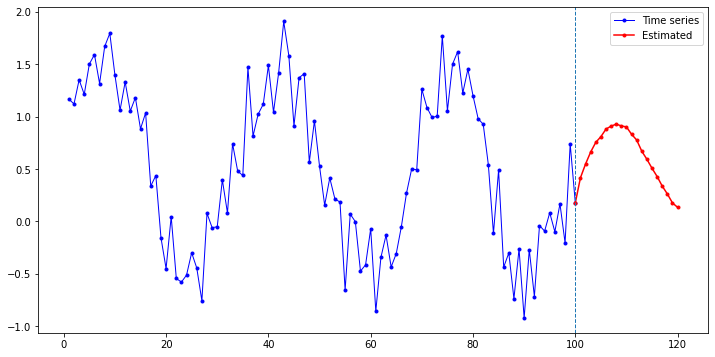

In [ ]:
# 이런 방식으로 20 기간까지 예측한다.
n_future = 20
n_last = 100

if len(data) > n_last:
    last_data = np.copy(data[-n_last:])  # 원 데이터의 마지막 n_last개만 그려본다
else:
    last_data = np.copy(data)

dx = np.copy(last_data)
estimated = [dx[-1][0]]
for i in range(n_future):
    # 마지막 t_step 만큼 입력데이터로 다음 값을 예측한다
    px = dx[-t_step:].reshape(1, t_step, 1)
    
    # 다음 값을 예측한다.
    y_hat = model.predict(px)[0][-1][0]
        
    # 예측값을 저장해 둔다
    estimated.append(y_hat)
    
    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    dx = np.insert(dx, len(dx), y_hat)

# 원 시계열과 예측된 시계열을 그린다
plt.figure(figsize=(12, 6))
ax1 = np.arange(1, len(last_data) + 1)
ax2 = np.arange(len(last_data), len(last_data) + len(estimated))
plt.plot(ax1, last_data, 'b-o', color='blue', markersize=3, label='Time series', linewidth=1)
plt.plot(ax2, estimated, 'b-o', color='red', markersize=3, label='Estimated')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.legend()
plt.show()